In [1]:
# Exploring the covariance in segregating sites
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Import the relevant functions / custom classes
import sys 
sys.path.insert(0, '../../src/')
from seg_sites_covar import *
from coal_cov import TwoLocusSimulation, TwoLocusTheoryConstant
from fit_corr_segsites import *
from plot_utils import *

import os
from tqdm import tqdm
from glob import glob

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
main_figdir = '../../plots/two_locus_stats/corrSASB_realdata/'
supp_figdir = '../../plots/supp_figs/two_locus_stats/corrSASB_realdata/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

%matplotlib inline

# Monte-Carlo Estimation for Haploid Samples

In [3]:
# Reading in the data
rec_rate_corr_piA_piB = pd.read_csv('../../results/corr_seg_sites/monte_carlo_est_LBK_UstIshim_modern.csv')
rec_rate_corr_piA_piB.head()

,ANC_ID,MOD_ID,rec_rate_mean,rec_rate_se,corr_piA_piB,se_corr_piA_piB
0,LBK,NA18486,0.000011,4.968652e-07,0.249415,0.006133
1,LBK,NA18486,0.000013,5.821711e-07,0.244006,0.006105
2,LBK,NA18486,0.000015,6.855675e-07,0.194202,0.006082
3,LBK,NA18486,0.000017,7.973908e-07,0.197501,0.005991
4,LBK,NA18486,0.000020,9.310998e-07,0.179601,0.005952


In [4]:
# Reading in a lot of VCF
pop_1kg_df = pd.read_table('../../data/raw_data/1kg_panel/integrated_call_samples_v3.20130502.ALL.panel')

test_yri_1kg = pop_1kg_df[pop_1kg_df['pop'] == 'YRI']['sample'].values[:3]
test_chb_1kg = pop_1kg_df[pop_1kg_df['pop'] == 'CHB']['sample'].values[:3]
test_ceu_1kg = pop_1kg_df[pop_1kg_df['pop'] == 'CEU']['sample'].values[:3]
test_gih_1kg = pop_1kg_df[pop_1kg_df['pop'] == 'GIH']['sample'].values[:3] 
test_indivs_1kg = np.hstack([test_yri_1kg, test_chb_1kg, test_ceu_1kg, test_gih_1kg])

In [5]:
mod_1kg = 'NA12383'
anc_ids = ['LBK', 'UstIshim']

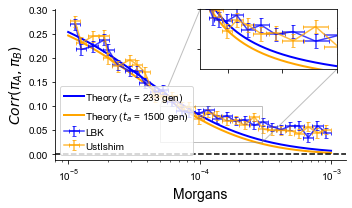

In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
axins = ax.inset_axes([0.5, 0.6, 0.47, 0.4])

# Make theory blue and orange ... 
colors = ['blue', 'orange']
idx = 0
for x in anc_ids:
    cur_df = rec_rate_corr_piA_piB[(rec_rate_corr_piA_piB['ANC_ID'] == x) & (rec_rate_corr_piA_piB['MOD_ID'] == mod_1kg)]
    ax.errorbar(rand_jitter(cur_df.rec_rate_mean, scale=1e-3), cur_df.corr_piA_piB, 
                xerr=2*cur_df.rec_rate_se, yerr=2*cur_df.se_corr_piA_piB, 
                capsize=2, alpha=0.75, color=colors[idx], label=r'%s' % anc_ids[idx]) 
    axins.errorbar(rand_jitter(cur_df.rec_rate_mean, scale=1e-3), cur_df.corr_piA_piB, 
                   xerr=2*cur_df.rec_rate_se, yerr=2*cur_df.se_corr_piA_piB,
                   capsize=2, alpha=0.75, color=colors[idx]) 
    idx += 1
    
    
# Use wattersons estimator on a sample of size 3? 
Ne = 1e4
gen_time = 30.
rec_rates = np.logspace(-5, -3, 1000)
idx = 0
for t in [7e3/gen_time, 45e3/gen_time]:
    corrs_test1 = TwoLocusTheoryConstant._corrSASB(4*Ne*rec_rates, ta=t/Ne/2, theta=4*Ne*1e3*1.2e-8)
    ax.plot(rec_rates, corrs_test1, lw=2, zorder=-1, color=colors[idx], label=r'Theory ($t_a$ = %d gen)' % t)
    axins.plot(rec_rates, corrs_test1, lw=2, zorder=-1, color=colors[idx], label=r'Theory ($t_a$ = %d gen)' % t)
    idx += 1
    
# sub region of the original image
x1, x2, y1, y2 = 5e-5, 3e-4, 0.025, 0.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins, label='')  
    
ax.legend(loc=3, fontsize=10, handletextpad=0.1);    
ax.set_xscale('log')
ax.axhline(y=0., linestyle='--', color='black')   
ax.set_xlabel(r'Morgans', fontsize=14)
ax.set_ylabel(r'$Corr(\pi_A,\pi_B)$', fontsize=14)
debox(ax);
plt.savefig(supp_figdir + 'ceu_ustishim_LBK_single_CEU.pdf', dpi=300, bbox_inches='tight')

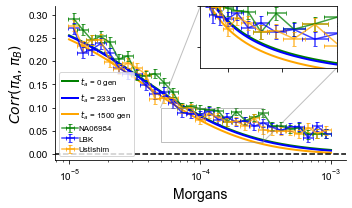

In [7]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
axins = ax.inset_axes([0.5, 0.6, 0.47, 0.4])

# Make theory blue and orange ... 
colors = ['green', 'blue', 'orange']
mod_id = 'NA12750'
idx = 0
for x in ['NA06984', 'LBK','UstIshim']:
    cur_df = rec_rate_corr_piA_piB[(rec_rate_corr_piA_piB['ANC_ID'] == x) & (rec_rate_corr_piA_piB['MOD_ID'] == mod_1kg)]
    ax.errorbar(cur_df.rec_rate_mean, cur_df.corr_piA_piB, 
                xerr=2*cur_df.rec_rate_se, yerr=2*cur_df.se_corr_piA_piB, 
                capsize=2, alpha=0.75, color=colors[idx], label=r'%s' % x) 
    axins.errorbar(cur_df.rec_rate_mean, cur_df.corr_piA_piB, 
                   xerr=2*cur_df.rec_rate_se, yerr=2*cur_df.se_corr_piA_piB,
                   capsize=2, alpha=0.75, color=colors[idx]) 
    idx += 1
    
    
# Use wattersons estimator on a sample of size 3? 
Ne = 1e4
gen_time = 30.
rec_rates = np.logspace(-5, -3, 1000)
idx = 0
for t in [0.0, 7e3/gen_time, 45e3/gen_time]:
    corrs_test1 = TwoLocusTheoryConstant._corrSASB(4*Ne*rec_rates, ta=t/Ne/2, theta=4*Ne*1e3*1.2e-8)
    ax.plot(rec_rates, corrs_test1, lw=2, zorder=-1, color=colors[idx], label=r' $t_a$ = %d gen' % t)
    axins.plot(rec_rates, corrs_test1, lw=2, zorder=-1, color=colors[idx], label=r' $t_a$ = %d gen' % t)
    idx += 1
    
# sub region of the original image
x1, x2, y1, y2 = 5e-5, 3e-4, 0.025, 0.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins, label='')  
    
ax.legend(loc=3, fontsize=8, handletextpad=0.0);    
ax.set_xscale('log')
ax.axhline(y=0., linestyle='--', color='black')   
ax.set_xlabel(r'Morgans', fontsize=14)
ax.set_ylabel(r'$Corr(\pi_A,\pi_B)$', fontsize=14)
debox(ax);
plt.savefig(supp_figdir + 'ceu_ustishim_LBK_single_CEU_w_modern.pdf', dpi=300, bbox_inches='tight')

# Averaging over many modern CEU samples

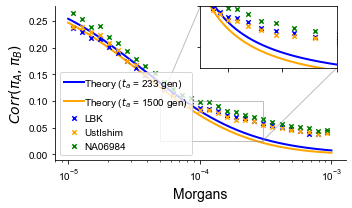

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
axins = ax.inset_axes([0.5, 0.6, 0.47, 0.4])

test_ceu_1kg = pop_1kg_df[pop_1kg_df['pop'] == 'CEU']['sample'].values
anc_ids = ['LBK', 'UstIshim', 'NA06984']

# Make theory blue and orange ... 
colors = ['blue', 'orange', 'green']
idx = 0
for a in anc_ids:
    # Getting the 
    cur_df_test = rec_rate_corr_piA_piB[(rec_rate_corr_piA_piB.ANC_ID == a) & (np.isin(rec_rate_corr_piA_piB.MOD_ID,test_ceu_1kg))]
    rec_rate_mean = [df_region.rec_rate_mean.values for _, df_region in cur_df_test.groupby('MOD_ID')]
    corr_piA_piB = [df_region.corr_piA_piB.values for _, df_region in cur_df_test.groupby('MOD_ID')]
    mean_rec_rates = np.vstack(rec_rate_mean)
    mean_corr_s1_s2 = np.vstack(corr_piA_piB)
    
#     ax.errorbar(np.mean(mean_rec_rates, axis=0), np.mean(mean_corr_s1_s2,axis=0),
#                 xerr=2*np.std(mean_rec_rates, axis=0), yerr=2*np.std(mean_corr_s1_s2, axis=0), 
#                 capsize=2, alpha=0.75, color=colors[idx], label=r'%s' % a) 

#     axins.errorbar(np.mean(mean_rec_rates,axis=0), np.mean(mean_corr_s1_s2,axis=0), 
#                 xerr=2*np.std(mean_rec_rates,axis=0), yerr=2*np.std(mean_corr_s1_s2, axis=0), 
#                 capsize=2, alpha=0.75, color=colors[idx], label=r'%s' % a)

    ax.scatter(np.mean(mean_rec_rates, axis=0), np.mean(mean_corr_s1_s2,axis=0), marker='x', s = 20, color=colors[idx], label=r'%s' % a) 
    axins.scatter(np.mean(mean_rec_rates, axis=0), np.mean(mean_corr_s1_s2,axis=0), marker='x', s = 20, color=colors[idx], label=r'%s' % a)
    idx += 1
    

Ne = 1e4
gen_time = 30.
rec_rates = np.logspace(-5, -3, 1000)
idx = 0
for t in [7e3/gen_time, 45e3/gen_time]:
    corrs_test1 = TwoLocusTheoryConstant._corrSASB(4*Ne*rec_rates, ta=t/Ne/2, theta=4*Ne*1e3*1.2e-8)
    ax.plot(rec_rates, corrs_test1, lw=2, zorder=-1, color=colors[idx], label=r'Theory ($t_a$ = %d gen)' % t)
    axins.plot(rec_rates, corrs_test1, lw=2, zorder=-1, color=colors[idx], label=r'Theory ($t_a$ = %d gen)' % t)
    idx += 1
    
# sub region of the original image
x1, x2, y1, y2 = 5e-5, 3e-4, 0.025, 0.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins, label='')  
    
ax.legend(loc=3, fontsize=10, handletextpad=0.00);    
ax.set_xscale('log')
# ax.axhline(y=0., linestyle='--', color='black')   
ax.set_xlabel(r'Morgans', fontsize=14)
ax.set_ylabel(r'$Corr(\pi_A,\pi_B)$', fontsize=14); 
plt.tight_layout(); debox(ax);
plt.savefig(main_figdir + 'ceu_ustishim_LBK_trial_all_ceu_samples.pdf', dpi=300, bbox_inches='tight')

### Generating a table for comparing differences in the correlation of pairwise differences

In [9]:
from scipy.stats import wilcoxon
from scipy.stats import binom 

def sign_test_corr_piA_piB(x, y, test='binom', **kwargs):
    """
        Function to compute a non-parametric sign test
    """
    assert(x.size == y.size)
    diff = x - y
#     print(diff)
    if test == 'wilcoxon':
        stat, pval = wilcoxon(x, y, **kwargs) 
    elif test == 'binom':
        npos = np.sum(diff > 0)
        nneg = np.sum(diff < 0)
        n = x.size
        stat = np.mean(diff)
        pval = binom.cdf(np.min([nneg, npos]), n=n, p=0.5) + (1. - binom.cdf(np.max([npos, nneg]), n=n, p=0.5))
    else:
        raise ValueError('Test is not supported!')
    return(diff, stat, pval)  

In [10]:
collapsed_rows = []
for sampID in tqdm(test_indivs_1kg):
    pop = pop_1kg_df[pop_1kg_df['sample'] == sampID]['pop'].values[0]
    filt_df = rec_rate_corr_piA_piB[rec_rate_corr_piA_piB['MOD_ID'] == sampID]
    if filt_df.size > 0:
        df1 = filt_df[filt_df.ANC_ID == 'LBK']
        df2 = filt_df[filt_df.ANC_ID == 'UstIshim']
        _, _, pval_wilcoxon = sign_test_corr_piA_piB(df1['corr_piA_piB'], df2['corr_piA_piB'], test='wilcoxon')
        _, stat, pval_binom = sign_test_corr_piA_piB(df1['corr_piA_piB'].values, df2['corr_piA_piB'].values, test='binom')
        cur_row = [sampID, pop, np.round(pval_wilcoxon,5), np.round(pval_binom,5)]
        collapsed_rows.append(cur_row)

# testing this?
df = pd.DataFrame(collapsed_rows)
df.columns = ['Sample ID', 'Population','p-value (Wilcoxon)', 'p-value (Binomial)']
df = df.sort_values('Population')
df.to_csv('../../results/corr_seg_sites/pvals_LBK_UstIshim_1kg_indivs.csv', index=False)
df

100%|██████████| 12/12 [00:00<00:00, 259.75it/s]


,Sample ID,Population,p-value (Wilcoxon),p-value (Binomial)
6,NA06984,CEU,0.62660,0.58466
7,NA06985,CEU,0.83724,0.85554
8,NA06986,CEU,0.32519,0.58466
3,NA18525,CHB,0.02522,0.36159
4,NA18526,CHB,0.00008,0.00001
5,NA18528,CHB,0.00052,0.00522
9,NA20845,GIH,0.40513,0.85554
10,NA20846,GIH,0.00710,0.04277
11,NA20847,GIH,0.00029,0.00006
0,NA18486,YRI,0.11199,0.20049
